# End-to-End Machine Learning Project

## Get the data

### Download the data

Dowloading the data from [GitHub](https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz)

In [1]:
import os
import tarfile
from six.moves import urllib

# initializing the paths
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("../datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

#### Quick look at the data

In [3]:
housing = load_housing_data()
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

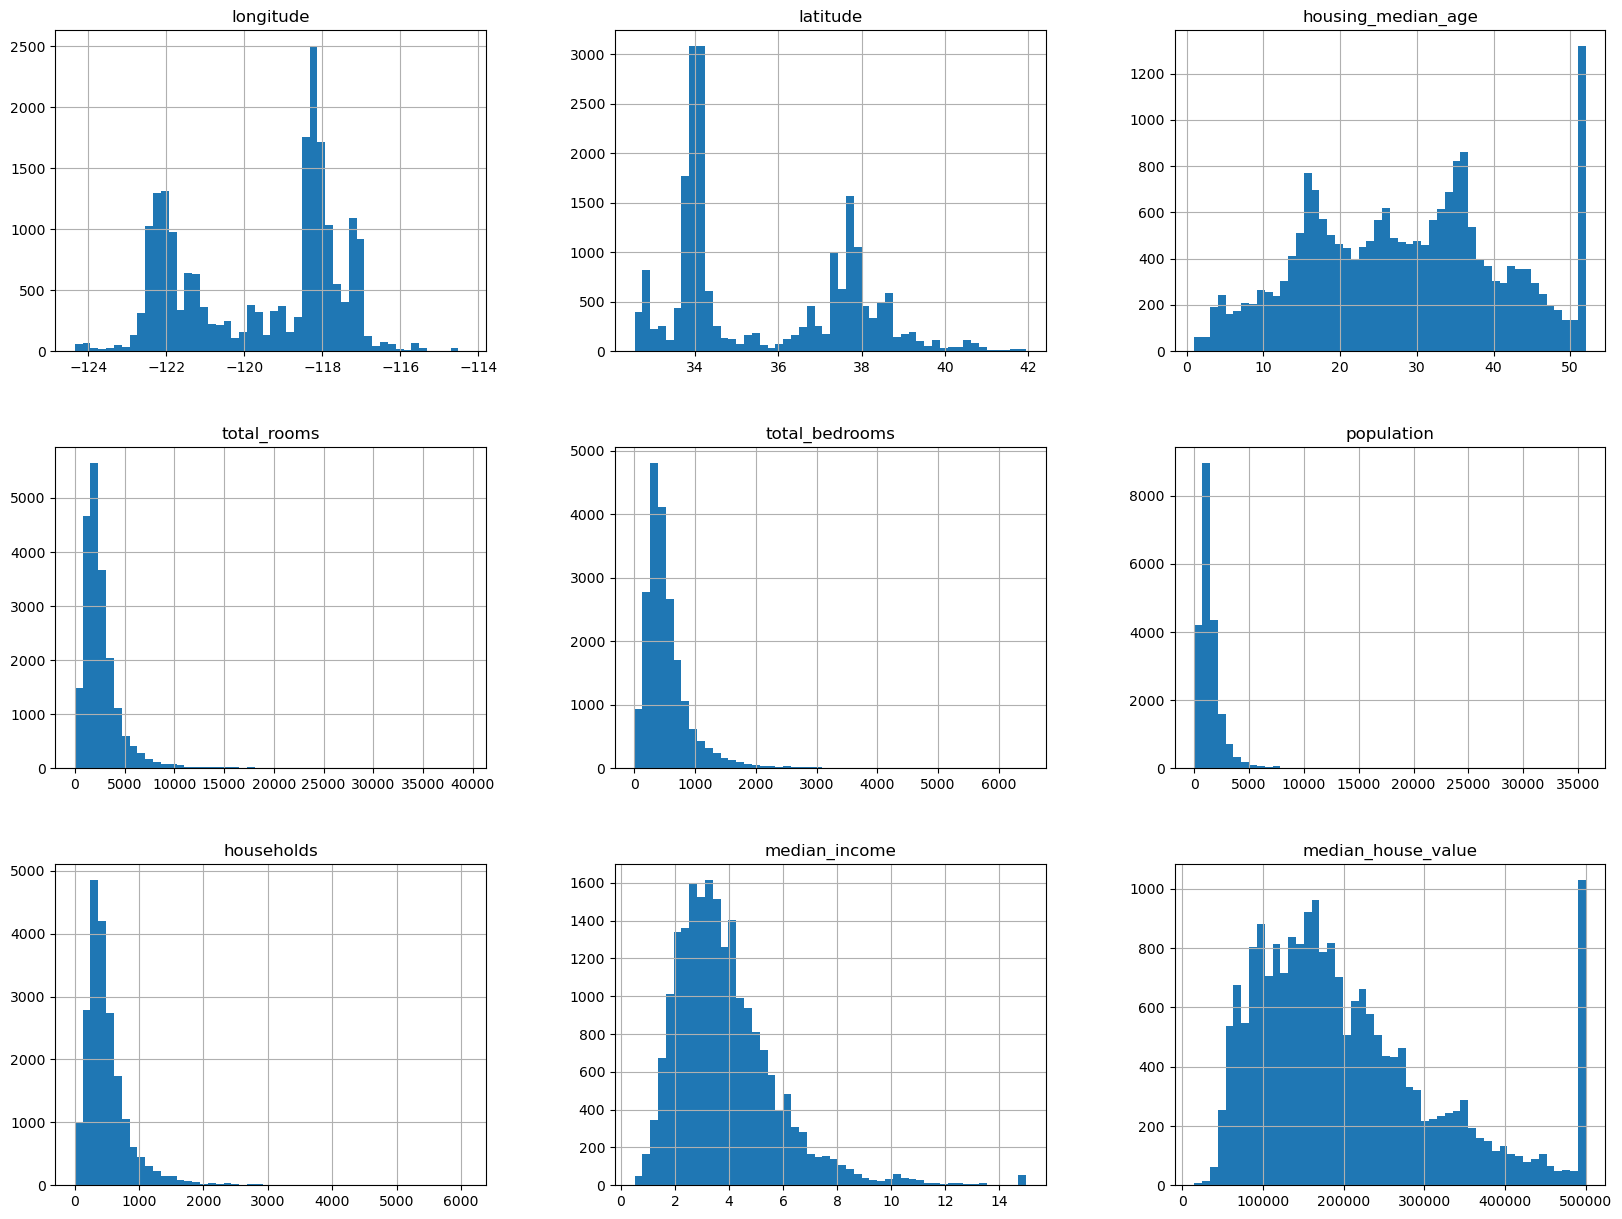

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

### Create Test & Train datasets

In [8]:
import numpy as np
np.random.seed(42)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)

len(train_set), len(test_set)

(16512, 4128)

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [12]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [13]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [14]:
test_set.head()

index  longitude  latitude  housing_median_age  total_rooms  \
8       8    -122.26     37.84                42.0       2555.0   
10     10    -122.26     37.85                52.0       2202.0   
11     11    -122.26     37.85                52.0       3503.0   
12     12    -122.26     37.85                52.0       2491.0   
13     13    -122.26     37.84                52.0        696.0   

    total_bedrooms  population  households  median_income  median_house_value  \
8            665.0      1206.0       595.0         2.0804            226700.0   
10           434.0       910.0       402.0         3.2031            281500.0   
11           752.0      1504.0       734.0         3.2705            241800.0   
12           474.0      1098.0       468.0         3.0750            213500.0   
13           191.0       345.0       174.0         2.6736            191300.0   

   ocean_proximity         id  
8         NEAR BAY -122222.16  
10        NEAR BAY -122222.15  
11        NEAR BAY -122222.15  
12        NEAR BAY -122222.15  
13        NEAR BAY -122222.16

In [15]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
test_set.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
20046    -119.01     36.06                25.0       1505.0             NaN   
3024     -119.46     35.14                30.0       2943.0             NaN   
15663    -122.44     37.80                52.0       3830.0             NaN   
20484    -118.72     34.28                17.0       3051.0             NaN   
9814     -121.93     36.62                34.0       2351.0             NaN   

       population  households  median_income  median_house_value  \
20046      1392.0       359.0         1.6812             47700.0   
3024       1565.0       584.0         2.5313             45800.0   
15663      1310.0       963.0         3.4801            500001.0   
20484      1705.0       495.0         5.7376            218600.0   
9814       1063.0       428.0         3.7250            278000.0   

      ocean_proximity  
20046          INLAND  
3024           INLAND  
15663        NEAR BAY  
20484       <1H OCEAN  
9814       NEAR OCEAN

<Axes: >

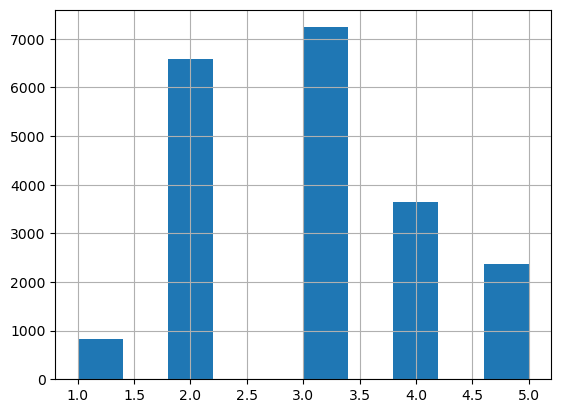

In [17]:
housing["income_cat"] = pd.cut(
                            housing["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5]
                        )
housing["income_cat"].hist()

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [21]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

<Axes: xlabel='longitude', ylabel='latitude'>

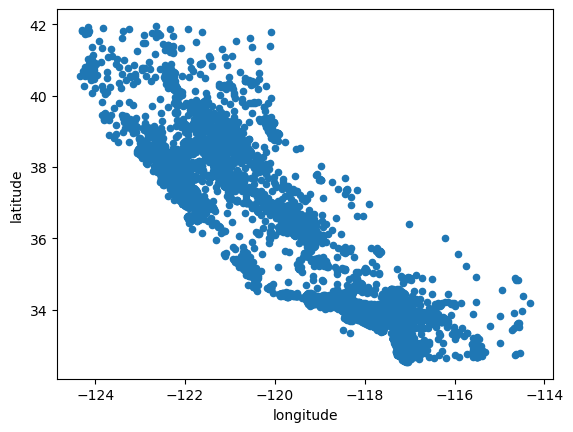

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

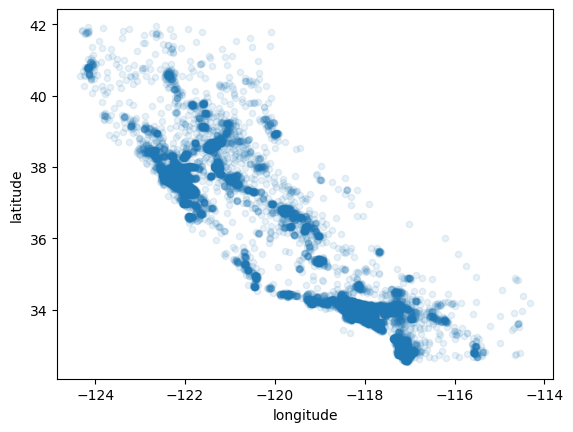

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

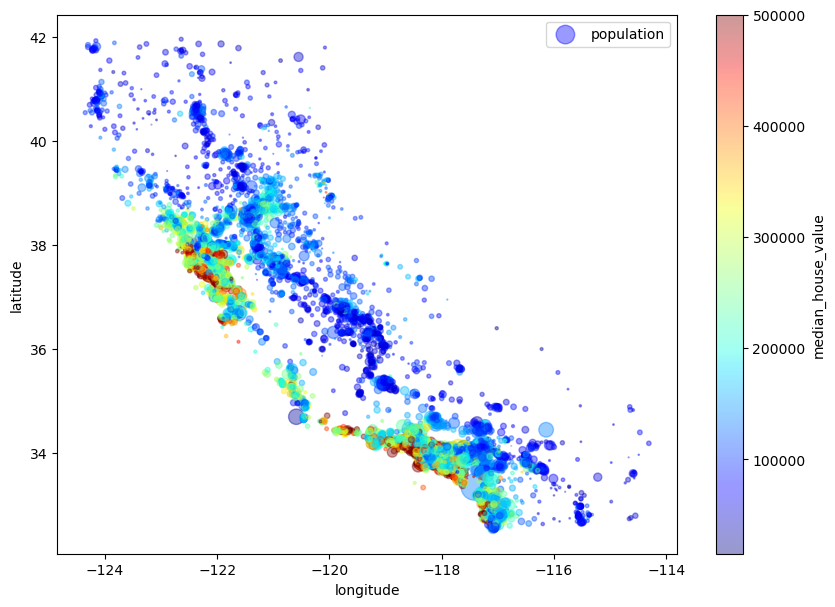

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

### Looking for Correlations

In [25]:
corr_matrix = housing.corr()

/tmp/ipykernel_2943/2466220658.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [26]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

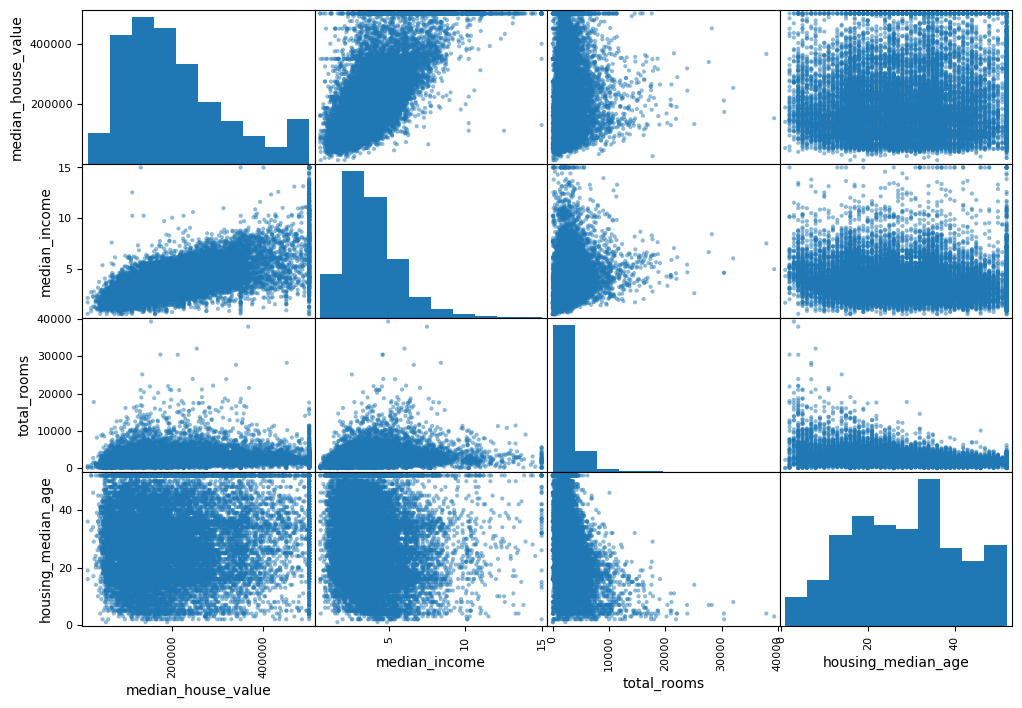

In [27]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
 "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

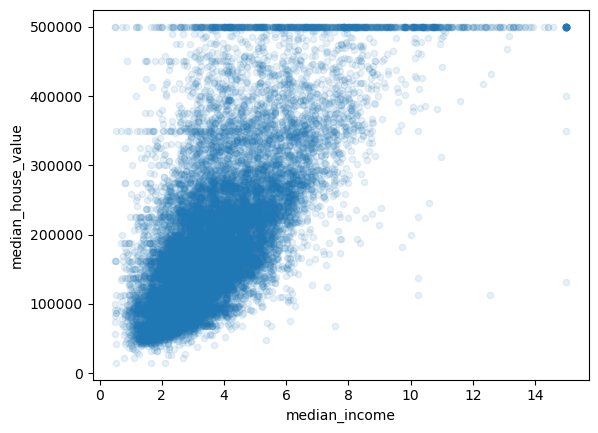

In [28]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
 alpha=0.1)
plt.show()

### Experimenting with Attribute Combinations

In [29]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [30]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

/tmp/ipykernel_2943/826279322.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

### Data Cleaning

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In the book 3 options are listed:
``` python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

In [32]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [33]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [34]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [35]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [36]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [37]:
X = imputer.transform(housing_num)

In [38]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
 index=housing_num.index)

In [39]:
housing_tr.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   

       population  households  median_income  
12655      2237.0       706.0         2.1736  
15502      2015.0       768.0         6.3373  
2908        667.0       300.0         2.8750  
14053       898.0       483.0         2.2264  
20496      1837.0       580.0         4.4964

### Handling Text and Categorical Attributes

In [40]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN

In [41]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [42]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [43]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [44]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [45]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Transformation Pipelines

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
     ('imputer', SimpleImputer(strategy="median")),
     ('attribs_adder', CombinedAttributesAdder()),
     ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [48]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [49]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [50]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [51]:
housing_prepared.shape

(16512, 16)

## Select and Train a Model

### Training and Evaluating on the Training Set

In [52]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [53]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [54]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [55]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [56]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Better Evaluation Using Cross-Validation

In [57]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
 scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [58]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72251.22610062 70811.34799853 68000.08591434 71929.39104752
 69328.61392367 77963.99482744 71628.79228943 73511.78648072
 69045.58722762 69854.4073967 ]
Mean: 71432.52332065887
Standard deviation: 2696.6824522410743


In [59]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818065


In [60]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [61]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18733.78842762556

In [62]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51340.22553753 49240.079874   46976.40445657 51917.1921677
 47035.53338226 51829.80557131 52841.15437862 49525.18429381
 47962.29506428 54069.20606905]
Mean: 50273.7080795117
Standard deviation: 2357.685647654302


### Fine-Tune Your Model

In [63]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [64]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [65]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [66]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63298.325280791854 {'max_features': 2, 'n_estimators': 3}
55270.34904709105 {'max_features': 2, 'n_estimators': 10}
52764.37907812309 {'max_features': 2, 'n_estimators': 30}
59915.231517953645 {'max_features': 4, 'n_estimators': 3}
52250.00971218671 {'max_features': 4, 'n_estimators': 10}
50523.76956271084 {'max_features': 4, 'n_estimators': 30}
58765.92610607112 {'max_features': 6, 'n_estimators': 3}
51730.966110363326 {'max_features': 6, 'n_estimators': 10}
49946.273624879475 {'max_features': 6, 'n_estimators': 30}
59277.60503739721 {'max_features': 8, 'n_estimators': 3}
52330.73545038374 {'max_features': 8, 'n_estimators': 10}
50227.668503643676 {'max_features': 8, 'n_estimators': 30}
62861.2715675933 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53857.8212549715 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60006.561171063295 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52604.14159908305 {'bootstrap': False, 'max_features': 3, 'n_estimators'

### Analyze the Best Models and Their Errors

In [67]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.02540413e-02, 7.30975513e-02, 4.21462904e-02, 1.94599329e-02,
       1.66305656e-02, 1.82993131e-02, 1.50495682e-02, 3.03111918e-01,
       6.20480248e-02, 1.06221557e-01, 8.14535860e-02, 9.36554568e-03,
       1.67342766e-01, 6.92925556e-05, 1.89090481e-03, 3.55914297e-03])

In [68]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.3031119176071169, 'median_income'),
 (0.16734276601874726, 'INLAND'),
 (0.10622155666897516, 'pop_per_hhold'),
 (0.0814535860261664, 'bedrooms_per_room'),
 (0.08025404133343494, 'longitude'),
 (0.07309755133984223, 'latitude'),
 (0.06204802478201258, 'rooms_per_hhold'),
 (0.04214629041432651, 'housing_median_age'),
 (0.019459932868257434, 'total_rooms'),
 (0.01829931310645658, 'population'),
 (0.016630565643715827, 'total_bedrooms'),
 (0.01504956816998999, 'households'),
 (0.009365545680866467, '<1H OCEAN'),
 (0.003559142973095881, 'NEAR OCEAN'),
 (0.001890904811381891, 'NEAR BAY'),
 (6.92925556139685e-05, 'ISLAND')]

### Evaluate Your System on the Test Set

In [69]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [70]:
final_rmse

47491.48557683056

In [71]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))

array([45481.8075141 , 49419.50616749])

In [72]:
import joblib
joblib.dump(final_model, "../artifacts/my_model.pkl") 

my_model_loaded = joblib.load("../artifacts/my_model.pkl")

## Exercise Solutions

### Question 1

Try a Support Vector Machine regressor (sklearn.svm.SVR), with various hyperparameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

In [73]:
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   5.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   6.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   6.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   5.9s
[CV] END ..............................C=30.0, kernel=linear; total time=   5.9s
[CV] END ..............................C=30.0, kernel=linear; total time=   5.8s
[CV] END ..............................C=30.0, kernel=linear; total time=   5.9s
[CV] END ..............................C=30.0, kernel=linear; total time=   5.8s
[CV] END ..............................C=30.0, kernel=linear; total time=   5.9s
[CV] END .............................C=100.0, kernel=linear; total time=   5.8s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [74]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70286.6183460516

In [75]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

### Question 2

Try replacing GridSearchCV with RandomizedSearchCV.

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.1s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.9s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.6s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   6.1s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.6s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.3s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.9s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.5s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  10.4s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff2674ff0d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff26ddd9050>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [77]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54751.69009256623

In [78]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

### Question 3

Try adding a transformer in the preparation pipeline to select only the most
important attributes.

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [80]:
k = 5
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12])

In [81]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'], dtype='<U18')

In [82]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3031119176071169, 'median_income'),
 (0.16734276601874726, 'INLAND'),
 (0.10622155666897516, 'pop_per_hhold'),
 (0.0814535860261664, 'bedrooms_per_room'),
 (0.08025404133343494, 'longitude')]

In [83]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [84]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [85]:
housing_prepared_top_k_features[0:3]

array([[-0.94135046, -0.8936472 ,  0.00622264, -0.12112176,  1.        ],
       [ 1.17178212,  1.292168  , -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.52543365, -0.07537122, -0.33827252,  1.        ]])

In [86]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046, -0.8936472 ,  0.00622264, -0.12112176,  1.        ],
       [ 1.17178212,  1.292168  , -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.52543365, -0.07537122, -0.33827252,  1.        ]])

### Question 4

Try creating a single pipeline that does the full data preparation plus the final prediction.

In [87]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  OneHotEncoder(...
                 TopFeatureSelector(feature_importances=array([8.02540413e-02, 7.30975513e-02, 4.21462904e-02, 1.94599329e-02,
       1.66305656e-02, 1.82993131e-02, 1.50495682e-02, 3.03111918e-01,
       6.20480248e-02, 1.06221557e-01, 8.14535860e-02, 9.36554568e-03,
       1.67342766e-01, 6.92925556e-05, 1.89090481e-03, 3.55914297e-03]),
                                    k=5)),
                ('svm_reg',
                 SVR(C=157055.10989448498, gamma=0.26497040005002437))])

In [88]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 82915.77062052 288057.72329294  95680.82648363 149790.34263836]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


### Question 5

Automatically explore some preparation options using GridSearchCV.

In [89]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   9.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   8.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   8.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   8.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   8.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   9.8s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   8.9s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   9.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   9.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total t

/home/sairam/miniconda3/envs/mle-dev/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sairam/miniconda3/envs/mle-dev/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sairam/miniconda3/envs/mle-dev/lib/python3.11/site-packages/sklearn/pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sairam/miniconda3/envs/mle-dev/lib/python3.11/si

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_inc...
       6.20480248e-02, 1.06221557e-01, 8.14535860e-02, 9.36554568e-03,
       1.67342766e-01, 6.92925556e-05, 1.89090481e-03, 3.55914297e-03]),
                                                           k=5)),
                                       ('svm_reg',
                                        SVR(C=157055.10989448498,
                                            gamma=0.26497040005002437))]),
             param_grid=[{'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16],
                          'preparation__num__imputer__strategy': ['mean',
                                                                  'median',
                                                                  'most_frequent']}],
             scoring='neg_mean_squared_error', verbose=2)

In [90]:
grid_search_prep.best_params_

{'feature_selection__k': 13,
 'preparation__num__imputer__strategy': 'most_frequent'}